In [247]:
wmf.utils.insert_code_toggle()

# Historical Activity of ClueBot NG

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**

**Last updated on 19 August 2023**

[TASK: T343952](https://phabricator.wikimedia.org/T343952)

# Contents

1. [Summary](#Summary)
2. [Data Gathering](#Data-Gathering)
3. [Analysis](#Analysis)

# Summary
[ClueBot (NG)](https://en.wikipedia.org/wiki/User:ClueBot_NG) is an anti-vandalism bot that tries to detect and revert vandalism quickly and automatically on English Wikipedia. The bot has been operational since 2010 and had varied levels of activity.
- The bot usually monitors content namespaces and for every revert that was made, a message is posted to the user's talk page whose edit had been reverted. 
    - While there were edits made in content namespaces that are not reverts, and reverts in non-content namespaces, their frequency is insigificant, and don't add any value to the analysis.
    - non-content reverts: 0.029% & content edits (excluding reverts): 0.009% of all time edits made by the bot
- From 2010 to early 2013, the bot made between 1500-2500 reverts on average per day.
- From 2013 to 2018, the average daily reverts were between 500-1000.
- From 2019 to mid-2020, the average daily reverts were between 150-250.
- Start July 2020, the average daily reverts increased to ~500, a trend which continued until the end of 2021.
- There was a sharp drop in the daily reverts made since Jan 2022; it continued to drop until August 2022 when the bot made 65 reverts on average per day.
- From Sep 2022 to Jun 2023 (end of data), the average daily reverts were between 150-200.

Note: As the bot posts a talk page message for each revert (in most cases), the actual edit count would approximately be double of average reverts mentioned above.

# Data-Gathering

## imports

In [243]:
import wmfdata as wmf
import pandas as pd

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

pd.options.display.max_columns = None

## spark_session

In [3]:
spark_session = wmf.spark.get_active_session()

if type(spark_session) != type(None):
    spark_session.stop()
else:
    print('no active session')

no active session


In [5]:
spark_session = wmf.spark.create_custom_session(
    master="yarn",
    app_name='cluebot-activity',
    spark_config={
        "spark.driver.memory": "4g",
        "spark.dynamicAllocation.maxExecutors": 64,
        "spark.executor.memory": "16g",
        "spark.executor.cores": 4,
        "spark.sql.shuffle.partitions": 256,
        "spark.driver.maxResultSize": "2g"
        
    }
)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 05:48:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [6]:
spark_session

In [7]:
spark_session.sparkContext.setLogLevel("ERROR")

## queryreverts

In [217]:
%%time

query = """
WITH
    base AS (
        SELECT 
            YEAR(event_timestamp) AS year,
            MONTH(event_timestamp) AS month,
            DAY(event_timestamp) AS day,
            DATE(event_timestamp) AS date,
            
            revision_id,
            CASE
                WHEN page_namespace_is_content AND revision_is_identity_revert THEN 'content_revert'
                WHEN page_namespace_is_content AND revision_is_identity_revert = False THEN 'content_edit'
                WHEN page_namespace_is_content = False AND revision_is_identity_revert THEN 'non_content_revert'
                WHEN page_namespace_is_content = False AND revision_is_identity_revert = False THEN 'non_content_edit'
            ELSE 'n/a'
            END AS edit_type            
        FROM
            wmf.mediawiki_history
        WHERE
            snapshot = '2023-07' AND
            wiki_db = 'enwiki' AND
            event_user_text = 'ClueBot NG' AND
            DATE(event_timestamp) <= DATE('2023-06-30') AND
            page_namespace_is_content IS NOT NULL AND
            revision_is_identity_revert IS NOT NULL
    )
            
        
SELECT
    year,
    month,
    day,
    edit_type,
    date,
    CAST(COUNT(DISTINCT revision_id) AS INT) AS edits
FROM 
    base
GROUP BY
    year,
    month,
    day,
    date,
    edit_type
ORDER BY
    year,
    month,
    day,
    date,
    edit_type
"""

result = wmf.spark.run(query)

CPU times: user 613 ms, sys: 94.1 ms, total: 707 ms
Wall time: 1min 16s


## data processing

In [220]:
# convert string to datetime datatype
result['ymonth'] = pd.to_datetime(result['date']).dt.strftime('%Y-%m')

In [221]:
# pivot based on edit type

data = (
    result
    .pivot(
        index=['year', 'month', 'day', 'ymonth'], 
        columns='edit_type', values='edits')
    .fillna(0)
    .astype(int)
)

data.columns = [col for col in data.columns]
data.head(3)

content_edit  content_revert  non_content_edit  \
year month day ymonth                                                    
2010 10    28  2010-10             0               0                 1   
     11    2   2010-11             0             690               688   
           3   2010-11             0            1769              1440   

                        non_content_revert  
year month day ymonth                       
2010 10    28  2010-10                   0  
     11    2   2010-11                   0  
           3   2010-11                   9

In [222]:
# aggregate to month level

data_monthly = (
    round(
        data
        .groupby(['year', 'month', 'ymonth'])
        .agg({
            'content_revert': ['sum', 'mean'], 
            'non_content_edit': ['sum', 'mean']
        })
    )
    .astype(int)
    .reset_index()
)

data_monthly.head(3)

year month   ymonth content_revert       non_content_edit      
                                  sum  mean              sum  mean
0  2010    10  2010-10              0     0                1     1
1  2010    11  2010-11          45176  1613            44905  1604
2  2010    12  2010-12          46536  1501            46604  1503

In [227]:
# save data
data_monthly.to_csv('cluebot_monthly_activity.tsv', sep='\t')

## Analysis

In [240]:
non_content_reverts_proportion = round(result.query("""edit_type == 'non_content_revert'""").edits.sum() / result.edits.sum() * 100, 3)
print(f"Percentage of non-content reverts: {non_content_reverts_proportion}%")

content_edits_proportion = round(result.query("""edit_type == 'content_edit'""").edits.sum() / result.edits.sum() * 100, 3)
print(f"Percentage of content edits (excluding reverts): {content_edits_proportion}%")

Percentage of non-content reverts: 0.029%
Percentage of content edits (excluding reverts): 0.009%


The bot usually monitors content namespaces and for every revert that was made, a message is posted to the user's talk page whose edit had been reverted. While there were edits made in content namespaces that are not reverts, and reverts in non-content namespaces, their frequency is insigificant, and don't add any value to the analysis.

## contenmt namespace reverts (line chart)

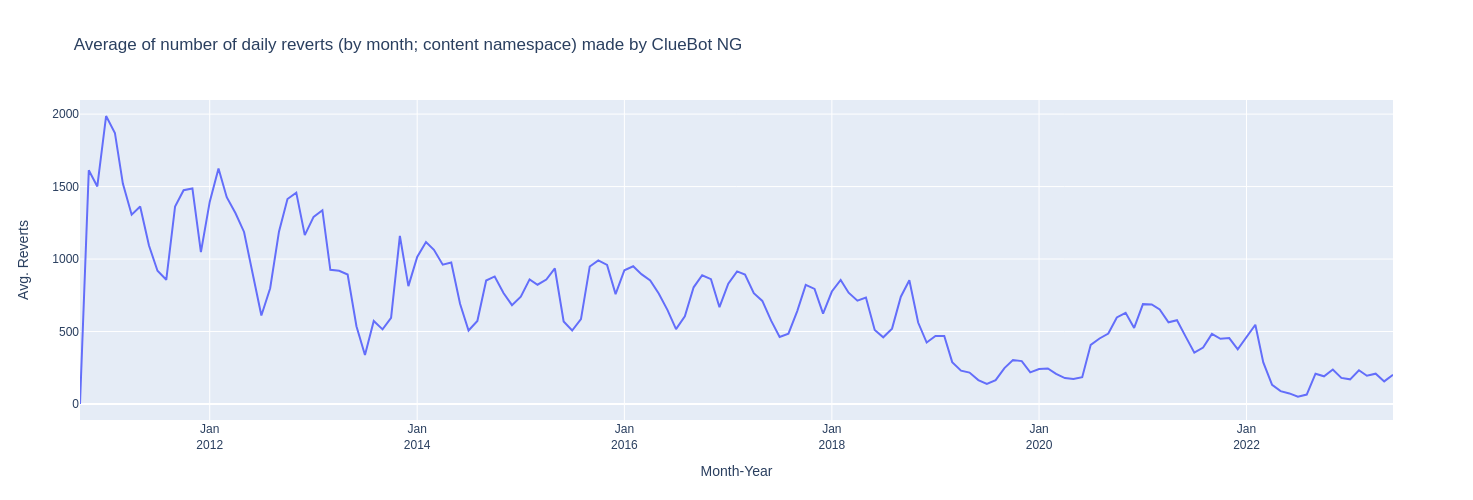

In [245]:
# line chart for reverts made in content namespaces

fig = (
    go
    .Figure([
        go.Scatter(
            x=data_monthly['ymonth'], 
            y=data_monthly.loc[:, ('content_revert', 'mean')])
    ])
    .update_layout(
        width=1250,
        height=500,
        title=dict(text='Average of number of daily reverts (by month; content namespace) made by ClueBot NG'),
        xaxis_tickformat= '%b<br>%Y'
    )
    .update_xaxes(title_text='Month-Year')
    .update_yaxes(title_text='Avg. Reverts')
)

fig.show()

## non-content namespace edits (line chart)

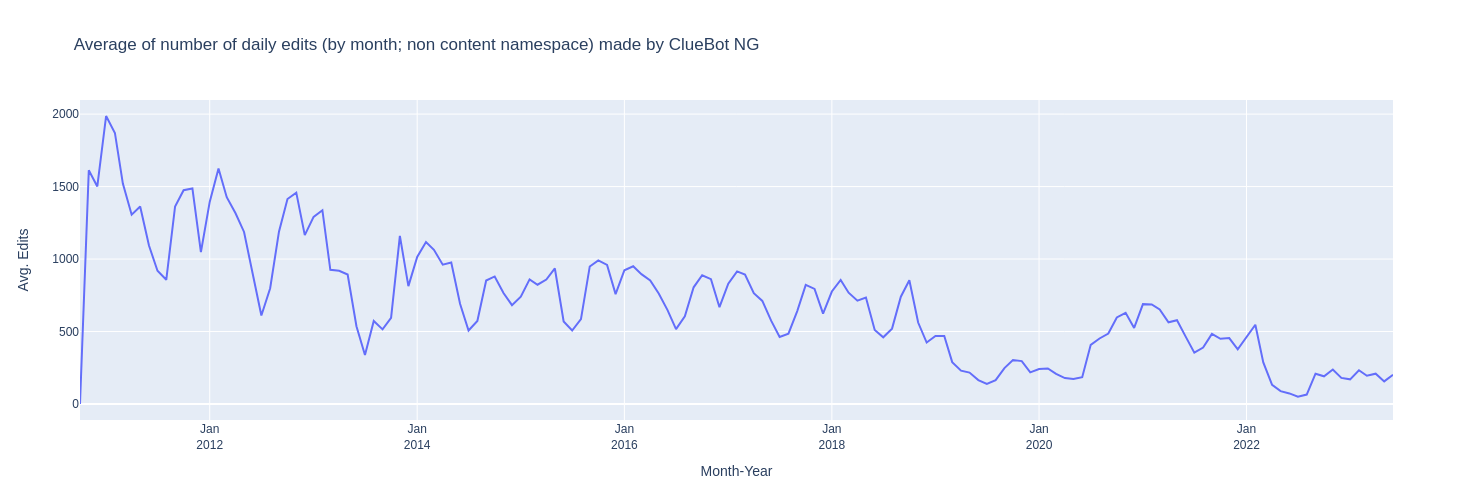

In [244]:
# line chart for edits made in non-content namespaces

fig = (
    go
    .Figure([
        go.Scatter(
            x=data_monthly['ymonth'], 
            y=data_monthly.loc[:, ('content_revert', 'mean')])
    ])
    .update_layout(
        width=1250,
        height=500,
        title=dict(text='Average of number of daily edits (by month; non content namespace) made by ClueBot NG'),
        xaxis_tickformat= '%b<br>%Y'
    )
    .update_xaxes(title_text='Month-Year')
    .update_yaxes(title_text='Avg. Edits')
)

fig.show()